In [46]:
import numpy as np
import matplotlib.pyplot as plt
from profit.sur.backend.gp_functions import invert, nll
from profit.sur.backend.kernels import kern_sqexp
from profit.util.halton import halton

In [47]:
def f(x): return x*np.cos(10*x)

# Custom function to build GP matrix
def build_K(xa, xb, hyp, K):
    for i in np.arange(len(xa)):
        for j in np.arange(len(xb)):
            K[i, j] = kern_sqexp(xa[i], xb[j], hyp[0])

noise_train = 0.0

ntrain = 30
xtrain = halton(1, ntrain)
ftrain = f(xtrain)
np.random.seed(0)
ytrain = ftrain + noise_train*np.random.randn(ntrain, 1)

In [48]:
# GP regression with fixed kernel hyperparameters
hyp = [0.5, 1e-6]  # l and sig_noise**2

K = np.empty((ntrain, ntrain))   # train-train
build_K(xtrain, xtrain, hyp, K)  # writes inside K
Ky = K + hyp[-1]*np.eye(ntrain)
Kyinv = invert(Ky, 4, 1e-6)       # using gp_functions.invert

ntest = 20
xtest = np.linspace(0, 1, ntest)
ftest = f(xtest)

Ks = np.empty((ntrain, ntest))  # train-test
Kss = np.empty((ntest, ntest))  # test-test
build_K(xtrain, xtest, hyp, Ks)
build_K(xtest, xtest, hyp, Kss)

fmean = Ks.T.dot(Kyinv.dot(ytrain)) # predictive mean

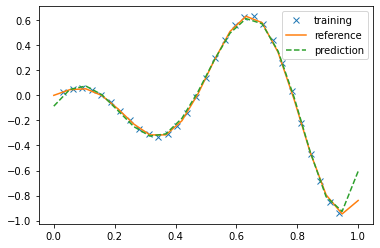

In [49]:
plt.figure()
plt.plot(xtrain, ytrain, 'x')
plt.plot(xtest, ftest, '-')
plt.plot(xtest, fmean, '--')
plt.legend(('training', 'reference', 'prediction'))

In [50]:
# Negative log likelihood over length scale
ls = np.linspace(1e-3, 3, 50)
nlls = np.array(
    [nll([l, 1e-3], xtrain, ytrain) for l in ls]
    ).flatten()

Text(0.5, 1.0, 'Negative log-likelihood')

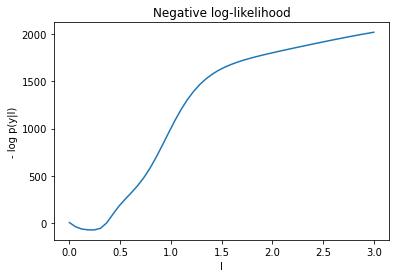

In [51]:
plt.figure()
plt.plot(ls, nlls)
plt.xlabel('l')
plt.ylabel('- log p(y|l)')
plt.title('Negative log-likelihood')

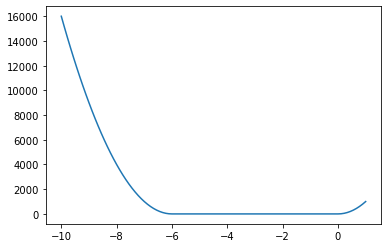

In [52]:
from scipy.optimize import minimize

# Prior to cut out range
def cutoff(x, xmin, xmax, slope=1e3):
    if x < xmin:
        return slope*(x - xmin)**2
    if x > xmax:
        return slope*(x - xmax)**2
    
    return 0.0

def nlprior(log10hyp):
    return cutoff(log10hyp[0], -2, 1) + cutoff(log10hyp[-1], -8, 0)

x = np.linspace(-10, 1, 100)
plt.figure()
plt.plot(x, [cutoff(xi, -6, 0) for xi in x])
plt.show()

def nlp_transform(log10hyp):
    hyp = 10**log10hyp
    return nll(hyp, xtrain, ytrain) + nlprior(log10hyp)

res = minimize(nlp_transform, np.array([-1, -6]), method='BFGS')

In [53]:
print(res)
print('[l,sig2] = ', 10**res.x)

      fun: -188.46713131182148
 hess_inv: array([[1.39706852e-11, 1.61798389e-10],
       [1.61798389e-10, 2.29592259e-09]])
      jac: array([ 5.83055305, 11.92432976])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 735
      nit: 10
     njev: 179
   status: 2
  success: False
        x: array([-0.6095278 , -8.00946117])
[l,sig2] =  [2.45737935e-01 9.78450435e-09]


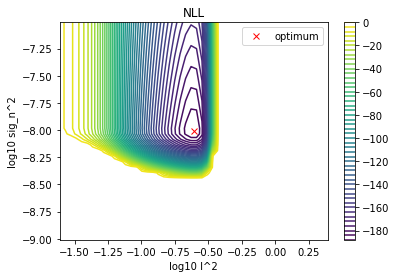

In [54]:
nl = 50
ns2 = 40

log10l = np.linspace(res.x[0]-1, res.x[0]+1, nl)
log10s2 = np.linspace(res.x[1]-1, res.x[1]+1, ns2)
[Ll, Ls2] = np.meshgrid(log10l, log10s2)

nlls = np.array(
    [nlp_transform(np.array([ll, ls2])) for ls2 in log10s2 for ll in log10l]
    ).reshape([ns2, nl])

# Do some cut for visualization
maxval = 0.0
nlls[nlls>maxval] = maxval

plt.figure()
plt.title('NLL')
plt.contour(Ll, Ls2, nlls, levels=50)
plt.plot(res.x[0], res.x[1], 'rx')
plt.xlabel('log10 l^2')
plt.ylabel('log10 sig_n^2')
plt.colorbar()
plt.legend(['optimum'])
plt.show()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

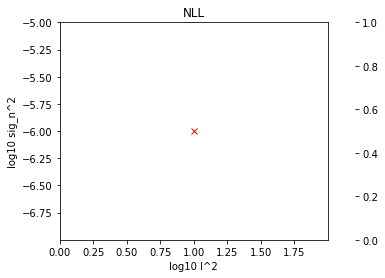

In [28]:
nlls